# Deep unsupervised learning HW 2

In [0]:
import numpy as np
def sample_data():
  count = 6000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y  = sample_data()

In [0]:
import matplotlib.pyplot as plt

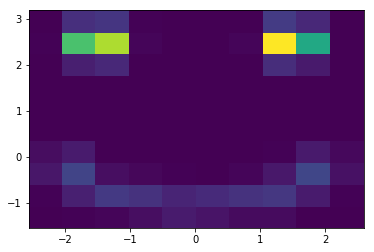

In [0]:
plt.hist2d(X[:,0],X[:,1])
plt.show()

Different paramters

In [0]:
import torch 
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F

In [0]:
class flow(nn.Module):
    
    def __init__(self,k=6):
        
        super(flow,self).__init__()
        self.k=k
        
        #layers
        self.layers= nn.Sequential(nn.Linear(1,100),
                                  nn.Tanh()
                                  )
        
        self.network = nn.Sequential(*self.layers)
        self.pi = nn.Linear(100,self.k)
        self.mu = nn.Linear(100,self.k)
        self.sigma = nn.Linear(100,self.k)

        
    def forward(self,x):
        x = self.network(x)
        pi = F.softmax(self.pi(x),dim=-1).view(-1,self.k)
        mu = self.mu(x).view(-1,self.k)
        sigma = torch.exp(self.sigma(x).view(-1,self.k))
        
        return pi, mu, sigma

        
class mycdf(nn.Module):
  
    def __init__(self, k=6):
    
      super(mycdf, self).__init__()
      self.k = k
      self.batch = 0
      self.pi = nn.Parameter(torch.randn(self.k,requires_grad=True))
      self.mu = nn.Parameter(torch.randn(self.k,requires_grad=True))
      self.sigma = nn.Parameter(torch.randn(self.k,requires_grad=True))
      
      self.fx2x1 = flow(self.k)
          
    
    def log_probs(self,x):
      x1,x2 = x[:,0],x[:,1]
      self.batch=x1.shape[0]
      
      x1 = x1.reshape(-1,1)
      x2 = x2.reshape(-1,1)
      

      pi1, mu1, sigma1 = F.softmax(self.pi.repeat(self.batch,1)),self.mu.repeat(self.batch,1),torch.exp(self.sigma.repeat(self.batch,1))
      pi2, mu2, sigma2 = self.fx2x1.forward(x1)
            
      
      #log_prob_x1 = torch.zeros(self.batch,1)
      log_prob_x2 = torch.zeros(self.batch,1)
      
      for i in range(self.k):
        #log_prob_x1 += pi1[:,i:i+1]*(Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).log_prob(x1).exp())
        log_prob_x2 += pi2[:,i:i+1]*(Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).log_prob(x2).exp())
      return log_prob_x2
    
    def loss(self,x):
      return torch.mean(-torch.log(self.log_probs(x)))


In [0]:
mycdf = mycdf(30)

In [0]:
mycdf.loss(torch.Tensor(X[0:2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(3.2390, grad_fn=<MeanBackward0>)

In [0]:
print(mycdf)
optimizer = torch.optim.Adam(mycdf.parameters(),lr=3e-4, weight_decay=0.0001)
for param in mycdf.parameters():
    print(type(param.data), param.size())

mycdf(
  (fx2x1): flow(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
    )
    (network): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
    )
    (pi): Linear(in_features=100, out_features=30, bias=True)
    (mu): Linear(in_features=100, out_features=30, bias=True)
    (sigma): Linear(in_features=100, out_features=30, bias=True)
  )
)
<class 'torch.Tensor'> torch.Size([30])
<class 'torch.Tensor'> torch.Size([30])
<class 'torch.Tensor'> torch.Size([30])
<class 'torch.Tensor'> torch.Size([100, 1])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([30, 100])
<class 'torch.Tensor'> torch.Size([30])
<class 'torch.Tensor'> torch.Size([30, 100])
<class 'torch.Tensor'> torch.Size([30])
<class 'torch.Tensor'> torch.Size([30, 100])
<class 'torch.Tensor'> torch.Size([30])


In [0]:
class DataSet:

    def __init__(self,X,y):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        
        self.images = X
        self.labels = y

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """

        img = self.images[idx]
        label = self.labels[idx]

        return img, label

In [0]:
ds = DataSet(torch.FloatTensor(X[:5000]),torch.FloatTensor(y[:5000]))
ds2 = DataSet(torch.FloatTensor(X[5000:5500]),torch.FloatTensor(y[5000:5500]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 2.788773775100708 val_loss 2.8395962715148926 
Epoch 100: loss 1.1908419132232666 val_loss 1.1832857131958008 
Epoch 200: loss 0.5279685854911804 val_loss 0.4924899637699127 
Epoch 300: loss 0.45758432149887085 val_loss 0.4291677474975586 
Epoch 400: loss 0.42946192622184753 val_loss 0.4034946858882904 
Epoch 500: loss 0.4099801182746887 val_loss 0.3835577070713043 
Epoch 600: loss 0.3946245610713959 val_loss 0.3664029538631439 
Epoch 700: loss 0.3804611563682556 val_loss 0.3504752814769745 
Epoch 800: loss 0.347687304019928 val_loss 0.3104380965232849 
Epoch 900: loss 0.3263089954853058 val_loss 0.29057615995407104 
Epoch 1000: loss 0.31165990233421326 val_loss 0.27569374442100525 
Epoch 1100: loss 0.3005983531475067 val_loss 0.26373177766799927 
Epoch 1200: loss 0.29214581847190857 val_loss 0.25417929887771606 
Epoch 1300: loss 0.28581100702285767 val_loss 0.24691186845302582 
Epoch 1400: loss 0.28097862005233765 val_loss 0.2410694658756256 
Epoch 1500: loss 0.277323842

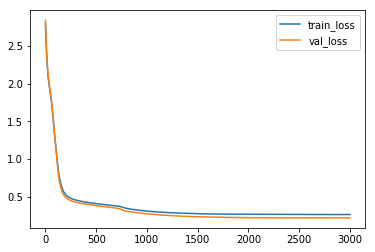

In [0]:
epochs=3000

losses, val_losses =[],[]
batch_size=500


train_iter = torch.utils.data.DataLoader(dataset=ds,batch_size=len(ds),shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=ds2,batch_size=len(ds2),shuffle=True)

losses = []
val_losses = []

for epoch in range(epochs):

    loss = 0
    for train_X, train_y in train_iter:

        loss = mycdf.loss(train_X)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())

        del loss
        loss = 0

        

    with torch.set_grad_enabled(False):
        for val_X, val_y in val_iter:
            val_loss = mycdf.loss(val_X)
            val_losses.append(val_loss.data.numpy())

    if epoch % 100 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

In [0]:
from torch.autograd import Variable
def sample_mode(pi, sigmasq, mu):
  # for prediction, could use conditional mode, but it doesn't
  # have an analytical solution (PRML p. 277). alternative is
  # to return the mean vector of the most probable component,
  # which is the approximate conditional mode from the mixture
  # NOTE: this breaks autograd, but that's fine because we
  # won't be computing gradients for this path
  # NOTE: pi, sigmasq, & mu are tensors
  n, k = pi.shape
  _, kt = mu.shape
  t = int(kt / k)
  _, max_component = torch.max(pi, 1)  # mixture w/ largest prob, i.e., argmax_k p(z==1)
  out = Variable(torch.zeros(n, t))
  for i in range(n):
    for j in range(t):
      out[i, j] = mu[i, max_component.data[i]*t+j]
  return out


def sample_preds(pi, sigmasq, mu, samples=1000):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out


In [0]:
pi1, mu1, sigma1 = F.softmax(mycdf.pi).view(1,-1),mycdf.mu.view(1,-1),torch.exp(mycdf.sigma).view(1,-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [0]:
preds_x = sample_preds(pi1, sigma1, mu1, samples=10000)

In [0]:
pi2, mu2, sigma2 = mycdf.fx2x1(preds_x)

In [0]:
predsx2 = sample_preds(pi2,sigma2,mu2,samples=1)

In [0]:
preds_x.shape

torch.Size([1, 1000, 1])

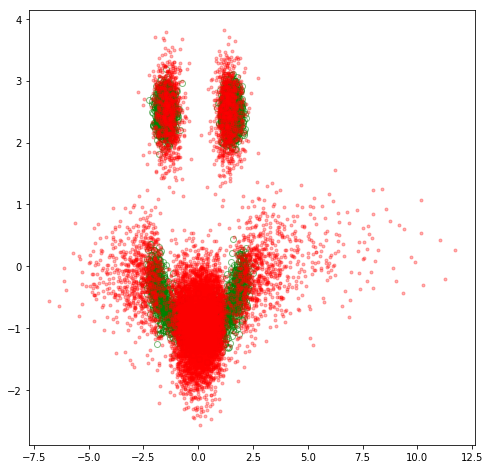

In [0]:
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'go', alpha=0.5, markerfacecolor='none')
for i in range(predsx2.shape[0]):
  plt.plot(preds_x.squeeze(0).detach().numpy()[i], predsx2.squeeze(1).numpy()[i], 'r.', alpha=0.3)
plt.show()

## RealNVP

In [0]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 8
#rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [0]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [0]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

Epoch 0: loss 4.791193962097168 val_loss 4.455811500549316 
Epoch 100: loss 1.8499244451522827 val_loss 1.8180183172225952 
Epoch 200: loss 1.5462356805801392 val_loss 1.485290288925171 
Epoch 300: loss 1.473760724067688 val_loss 1.4015341997146606 
Epoch 400: loss 1.4328422546386719 val_loss 1.3607068061828613 
Epoch 500: loss 1.4097005128860474 val_loss 1.3389495611190796 
Epoch 600: loss 1.3934580087661743 val_loss 1.3251596689224243 
Epoch 700: loss 1.380553960800171 val_loss 1.3267284631729126 
Epoch 800: loss 1.3780399560928345 val_loss 1.3162448406219482 
Epoch 900: loss 1.3709025382995605 val_loss 1.3130033016204834 


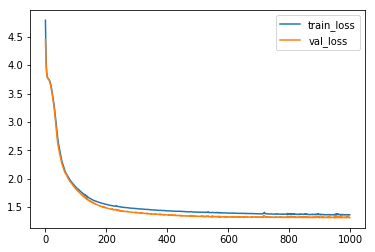

In [0]:
epochs=1000
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
batch_size=500


train_iter = torch.utils.data.DataLoader(dataset=ds,batch_size=len(ds),shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=ds2,batch_size=len(ds2),shuffle=True)

losses = []
val_losses = []

for epoch in range(epochs):

    loss = 0
    for train_X, train_y in train_iter:
      
        loss = -flow.log_prob(train_X).mean()

        loss.backward(retain_graph=True)    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())

        del loss
        loss = 0

        

    with torch.set_grad_enabled(False):
        for val_X, val_y in val_iter:
            val_loss = -flow.log_prob(val_X).mean()
            val_losses.append(val_loss.data.numpy())

    if epoch % 100 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

#for t in range(5001):    
    #noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
#    loss = -flow.log_prob(torch.from_numpy(data.astype(np.float32))).mean()
    
#    optimizer.zero_grad()
#    loss.backward(retain_graph=True)
#    optimizer.step()
    
#    if t % 500 == 0:
#        print('iter %s:' % t, 'loss = %.3f' % loss)

array([[-0.969312  , -1.723027  ],
       [ 2.0786195 ,  1.8896178 ],
       [-1.120279  , -0.5105021 ],
       ...,
       [ 0.85011953, -0.19426137],
       [-0.27923554, -0.65206987],
       [ 0.8996635 , -1.7622066 ]], dtype=float32)

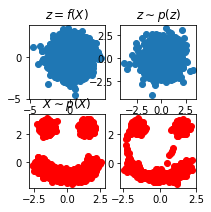

In [0]:
fig = plt.figure(figsize=(3, 3))
z = flow.f(train_X)[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')


plt.subplot(223)
x = train_X #datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
